See code at https://github.com/google-research/vision_transformer/

See paper at https://arxiv.org/abs/2010.11929

This Colab allows you to run the [JAX](https://jax.readthedocs.org) implementation of the Vision Transformer.

## 1) Using generator

### 1.1) Download the dataset and unpack it on the colab machine

In [1]:
!pwd
!mkdir dataset
!ls

/content
mkdir: cannot create directory ‘dataset’: File exists
dataset  sample_data


In [2]:
!wget -c "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" -P dataset/
!ls dataset/

--2021-03-03 11:58:50--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 69.192.208.109, 2600:1407:f800:49b::e59, 2600:1407:f800:4a5::e59
Connecting to download.microsoft.com (download.microsoft.com)|69.192.208.109|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

CatsAndDogs  kagglecatsanddogs_3367a.zip


In [3]:
# Quiet and overwrite, will create folder and unpack in CatsAndDogs
!unzip -qo dataset/kagglecatsanddogs_3367a.zip -d dataset/CatsAndDogs

In [4]:
# Print the number of cats and dogs images in the set
!ls -l dataset/CatsAndDogs/PetImages/Cat/*.jpg | wc -l
!ls -l dataset/CatsAndDogs/PetImages/Dog/*.jpg | wc -l

12500
12500


In [5]:
# Sanity check for later
!ls dataset/CatsAndDogs/PetImages/Cat/*.jpg | sed -E 's#.*/##' | sort > /tmp/Cats.txt
!ls dataset/CatsAndDogs/PetImages/Dog/*.jpg | sed -E 's#.*/##' | sort > /tmp/Dogs.txt
!diff /tmp/Cats.txt /tmp/Dogs.txt

### 1.2) Find the corrupted files



#### Find the corrupted files

In [6]:
# Will be quiet, except for errors
# see [https://peteris.rocks/blog/quiet-and-unattended-installation-with-apt-get/]
!apt-get install imagemagick -qq > /dev/null

In [7]:
# Examples that are corrupted : Cat/1418.jpg, Cat/4293.jpg, Cat/666.jpg

# Can take a bit of time to check all 25000 images
!mogrify -set comment 'Image rewritten with ImageMagick' dataset/CatsAndDogs/PetImages/*/*.jpg |& tee dataset/CatsAndDogs/mogrify_output
#!cat dataset/CatsAndDogs/mogrify_output

mogrify-im6.q16: Corrupt JPEG data: 239 extraneous bytes before marker 0xd9 `dataset/CatsAndDogs/PetImages/Cat/12303.jpg' @ warning/jpeg.c/JPEGWarningHandler/352.
mogrify-im6.q16: Corrupt JPEG data: 214 extraneous bytes before marker 0xd9 `dataset/CatsAndDogs/PetImages/Cat/1418.jpg' @ warning/jpeg.c/JPEGWarningHandler/352.
mogrify-im6.q16: Corrupt JPEG data: 128 extraneous bytes before marker 0xd9 `dataset/CatsAndDogs/PetImages/Cat/1614.jpg' @ warning/jpeg.c/JPEGWarningHandler/352.
mogrify-im6.q16: length and filesize do not match `dataset/CatsAndDogs/PetImages/Cat/4293.jpg' @ error/bmp.c/ReadBMPImage/826.
mogrify-im6.q16: Corrupt JPEG data: 99 extraneous bytes before marker 0xd9 `dataset/CatsAndDogs/PetImages/Cat/6421.jpg' @ warning/jpeg.c/JPEGWarningHandler/352.
mogrify-im6.q16: Corrupt JPEG data: 99 extraneous bytes before marker 0xd9 `dataset/CatsAndDogs/PetImages/Cat/6421.jpg' @ warning/jpeg.c/JPEGWarningHandler/352.
mogrify-im6.q16: insufficient image data in file `dataset/CatsAn

#### Fix some problems with a certain picture in Cats (handmade)

In [8]:
# Sanity check for later
!ls dataset/CatsAndDogs/PetImages/Cat/*.jpg | sed -E 's#.*/##' | sort > /tmp/Cats.txt
!ls dataset/CatsAndDogs/PetImages/Dog/*.jpg | sed -E 's#.*/##' | sort > /tmp/Dogs.txt
!diff /tmp/Cats.txt /tmp/Dogs.txt

450,452c450
< 10404-0.jpg
< 10404-1.jpg
< 10404-2.jpg
---
> 10404.jpg


In [9]:
# Cat 10404 has three versions...
from google.colab import files
import time
files.view('dataset/CatsAndDogs/PetImages/Cat/10404-0.jpg')
time.sleep(0.5)
files.view('dataset/CatsAndDogs/PetImages/Cat/10404-1.jpg')
time.sleep(0.5)
files.view('dataset/CatsAndDogs/PetImages/Cat/10404-2.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
!rm dataset/CatsAndDogs/PetImages/Cat/10404-1.jpg dataset/CatsAndDogs/PetImages/Cat/10404-2.jpg
!mv dataset/CatsAndDogs/PetImages/Cat/10404-0.jpg dataset/CatsAndDogs/PetImages/Cat/10404.jpg

In [11]:
# Sanity check for later
!ls dataset/CatsAndDogs/PetImages/Cat/*.jpg | sed -E 's#.*/##' | sort > /tmp/Cats.txt
!ls dataset/CatsAndDogs/PetImages/Dog/*.jpg | sed -E 's#.*/##' | sort > /tmp/Dogs.txt
!diff /tmp/Cats.txt /tmp/Dogs.txt

### 1.3) Create the exclusion and description files

#### Functions to create the exclusion list and the global description

In [12]:
from pathlib import Path
import re

import time

def checkExistanceAndEmptiness(output_file_path:str, doOverwrite:bool):
  okayToOverwrite = True
  output_path = Path(output_file_path)
  if output_path.exists():
    print('File exists')
    if output_path.stat().st_size != 0:
      print('File is not empty')
      if not doOverwrite:
        okayToOverwrite = False
        print('not over-writing')
      else:
        mode = 'w+'
        print('over-writing')
      
    else:
      print('File is empty')
      mode = 'w+'

  else:
    print('File don\'t exist')
    mode = 'w'
  return mode, okayToOverwrite

def createExclusionFile(dataset_dir_path:str, mogrify_output_file_path:str,
                        output_file_path:str, doOverwrite:bool=False):
  """
  dataset_dir_path le chemin d'accès au dossier du dataset
  output_file_path le chemin du fichier que l'on veut créer
  doOverwrite permet d'écraser le fichier, si il existe déjà, si le paramètre
    est passé à True (False par defaut).
  """
  print

  # Check if file exists or not and gives the write or write and read depending,
  # as well as the bolean to overwrite or not the file
  mode, okayToOverwrite = checkExistanceAndEmptiness(output_file_path, doOverwrite)

  dataset_path = Path(dataset_dir_path)
  output_path = Path(output_file_path)
  print(dataset_path)
  if okayToOverwrite:
    with output_path.open(mode) as outfile:
      #writing in the file

      # Lecture du fichier d'exclusion
      mogrify_output = Path(mogrify_output_file_path)
      regex_files = re.compile('dataset/.*/[0-9]*.jpg')

      added_lines = []
      with mogrify_output.open('r') as infile:
          for line in infile.readlines():
              # time.sleep(1)
              if line.endswith("\n"):
                  line = line[:-1]

                  first_match = regex_files.findall(line)[0]
                  first_path = Path(first_match)
                  string = str(first_path.relative_to(dataset_path))
                  # string = first_match.replace(str(dataset_path)+"/", "")
                  
                  if string not in added_lines:
                    outfile.write(string+"\n")
                    added_lines.append(string)

def createGlobalDescription(dataset_dir_path:str, exclude_img_file_path:str,
                           output_file_path:str, doOverwrite:bool=False):
  """
  Va generer le fichier de tout le dataset
  dataset_dir_path le chemin d'accès au dossier du dataset
  exclude_img_file_path le chemin d'accès d'un fichier d'exclusion de fichiers
    corrompus dans la liste. De la forme :
      path/vers/le/fichier1.jpg
      path/vers/le/fichier2.jpg
      path/vers/le/fichier3.jpg
      path/vers/le/fichier4.jpg
  output_file_path le chemin du fichier que l'on veut créer
  doOverwrite permet d'écraser le fichier, si il existe déjà, si le paramètre
    est passé à True (False par defaut).
  """

  # Lecture du fichier d'exclusion
  exclude_path = Path(exclude_img_file_path)
  exclude_img_list = []
  with exclude_path.open('r') as file:
      for line in file.readlines():
          if line.endswith("\n"):
              line = line[:-1]
              line = str(Path(line)) # To be able to compare it to other file path
              #print("exclude file line :", line)
          
          exclude_img_list.append(line)
  print("exclude_img_list", exclude_img_list)

  # Compter celui qui a le plus d'exclus, pour en avoir le même nombre de
  # chaque coté
  count_cat = 0; count_dog = 0
  for exclude_file in exclude_img_list:
    #print("Cat or Dog ?", exclude_file.split("/")[-2])
    if exclude_file.split("/")[-2] == 'Cat':
      count_cat += 1
    else:
      count_dog += 1
  print("count_cat", count_cat, "count_dog", count_dog)
  left_to_exclude_dogs = count_cat-count_dog if count_cat >= count_dog else 0
  left_to_exclude_cats = count_dog-count_cat if count_dog >= count_cat else 0

  # Check if file exists or not and gives the write or write and read depending,
  # as well as the bolean to overwrite or not the file
  mode, okayToOverwrite = checkExistanceAndEmptiness(output_file_path, doOverwrite)

  output_path = Path(output_file_path)
  # Ecriture du fichier
  if okayToOverwrite:
    with output_path.open(mode) as file:
      #writing in the file
      ds_dir_path = Path(dataset_dir_path)
      #print("ds_dir_path", ds_dir_path)

      class_num = -1
      for class_dir in ds_dir_path.joinpath("PetImages").iterdir():
        if class_dir.is_dir():
          class_num += 1
          print("  class_dir", class_dir)
          print("  class_num", class_num)

          if str(class_dir).endswith('Cat'):
            left_to_exclude_count = left_to_exclude_cats
            print("  left_to_exclude_count for Cats is :", left_to_exclude_count)
          else:
            left_to_exclude_count = left_to_exclude_dogs
            print("  left_to_exclude_count for Dogs is :", left_to_exclude_count)

          added_count = 0
          for class_img in class_dir.iterdir():
            if class_img.match('[0-9]*.jpg'):
              
              local_image_path = class_img.relative_to(ds_dir_path)
              # Check for exclusion


              #print("class_img:", class_img)
              #print("exclude_img_list:", exclude_img_list)
              #print("class_img relative to:", str(class_img.relative_to(ds_dir_path)))
              #time.sleep(2)
              if str(local_image_path) not in exclude_img_list:
                #print("    ds_dir_path", ds_dir_path)
                #print("    class_dir", class_dir)
                #print("    class_img", class_img)
                if left_to_exclude_count > 0:
                  left_to_exclude_count -= 1
                  #print("    class_img", class_img)
                  print("    > that was a left to exclude", local_image_path)
                  #time.sleep(1)
                else:
                  file.write(str(local_image_path) + "\t" + str(class_num) + "\n")
                  added_count += 1
              else:
                #print("    class_img", class_img)
                print("    > excluded from the exclusion list", local_image_path)
                #time.sleep(1)
          
          if str(class_dir).endswith('Cat'):
            print("Added", added_count, "cats to the description file")
          else:
            print("Added", added_count, "dogs to the description file")

#### Create the exclusion list and the global description

In [13]:
createExclusionFile(dataset_dir_path='./dataset/CatsAndDogs',
                    mogrify_output_file_path='./dataset/CatsAndDogs/mogrify_output',
                    output_file_path='./dataset/CatsAndDogs/exclude.txt',
                    doOverwrite=True)

createGlobalDescription(dataset_dir_path='./dataset/CatsAndDogs',
                        exclude_img_file_path='./dataset/CatsAndDogs/exclude.txt',
                        output_file_path='./dataset/CatsAndDogs/description.txt',
                        doOverwrite=True)

File exists
File is not empty
over-writing
dataset/CatsAndDogs
exclude_img_list ['PetImages/Cat/12303.jpg', 'PetImages/Cat/1418.jpg', 'PetImages/Cat/1614.jpg', 'PetImages/Cat/4293.jpg', 'PetImages/Cat/6421.jpg', 'PetImages/Cat/666.jpg', 'PetImages/Cat/7201.jpg', 'PetImages/Dog/10733.jpg', 'PetImages/Dog/11702.jpg', 'PetImages/Dog/12100.jpg', 'PetImages/Dog/3119.jpg', 'PetImages/Dog/4203.jpg', 'PetImages/Dog/4297.jpg', 'PetImages/Dog/4323.jpg', 'PetImages/Dog/4352.jpg', 'PetImages/Dog/5936.jpg', 'PetImages/Dog/7002.jpg', 'PetImages/Dog/7654.jpg']
count_cat 7 count_dog 11
File exists
File is not empty
over-writing
  class_dir dataset/CatsAndDogs/PetImages/Dog
  class_num 0
  left_to_exclude_count for Dogs is : 0
    > excluded from the exclusion list PetImages/Dog/7654.jpg
    > excluded from the exclusion list PetImages/Dog/10733.jpg
    > excluded from the exclusion list PetImages/Dog/12100.jpg
    > excluded from the exclusion list PetImages/Dog/11702.jpg
    > excluded from the exclu

### 1.4) Create a training and a test set

##### The python generator for the dataset

In [14]:
from pathlib import Path
import tensorflow as tf
import numpy as np
import cv2
import random
import math

class MyDogsCats:
    def __init__(self, ds_description_path:str, dataset_path:str, set_type:str,
                 train_prop:float, doDataAugmentation:bool=False, doInceptionCrop:bool=True) -> None:
        """
        ds_description_path : fichier avec les paths de chaque fichiers du dataset et sa classe
        Exemple de fichier (tabulation entre le path et la classe):
          /truc/bidule/chat/01.jpg  0
          /truc/bidule/chien/01.jpg 1
          Etc ...
        """

        # Lire le fichier de description et regrouper par classes
        img_list_par_classes = {}
        path = Path(ds_description_path)
        with path.open('r') as file:
          for line in file.readlines():
            if line.endswith("\n"):
              line = line[:-1]
            splits = line.split("\t")

            if line != "":
              img_text = splits[0]
              lbl_text = int(splits[1])

              if lbl_text in img_list_par_classes.keys():
                img_list_par_classes[lbl_text].append(img_text)
              else:
                img_list_par_classes[lbl_text] = [img_text]

        #print(img_list_par_classes)

        # Obtenir la liste de train OU de test
        self._img_list = []
        self._lbl_list = []
        self._num_class = len(img_list_par_classes)

        for num_class in img_list_par_classes:
          # Definir les proportions
          num_files_class_k = len(img_list_par_classes[num_class])
          # num_files = len(img_list_par_classes[num_class])
          if set_type == "train":
            
            num_per_class_to_keep = math.ceil(num_files_class_k * train_prop)
            # num_per_class_to_keep = math.ceil((num_files // self._num_class) * train_prop)

            class_files = img_list_par_classes[num_class][0:num_per_class_to_keep]
          
          elif set_type == "test":
            num_per_class_to_keep = math.floor(num_files_class_k * (1 - train_prop))
            # num_per_class_to_keep = math.floor((num_files // self._num_class) * (1 - train_prop))

            class_files = img_list_par_classes[num_class][-num_per_class_to_keep:]
          
          else:
            class_files = img_list_par_classes[num_class]
          
          # Ajouter les images qui correspondent à la liste des images
          self._img_list.extend(class_files)
          # De même pour les labels
          #print("num_class:", num_class)
          #print("type num_class:", type(num_class))
          #print("len num_class:", len(class_files))
          self._lbl_list.extend([num_class for i in range(len(class_files))])

        #print("_img_list", self._img_list[0:100])
        #print("_lbl_list", self._lbl_list[0:100])
        assert(len(self._lbl_list) == len(self._img_list))

        self.num_samples = len(self._lbl_list)

        if set_type == "train" or set_type == "test":
          self._set_type = set_type
        else:
          self._set_type = "whole"
        
        self._img_size = 384
        self._img_dim = (self._img_size, self._img_size)
        self._num_channels = 3
        self._one_hot_depth = self._num_class

        self._do_data_augmentation = doDataAugmentation
        self._do_inception_crop = doInceptionCrop

        self._ds_path = Path(dataset_path)
    
    def getDataset(self):
        generator = self._generator
        return tf.data.Dataset.from_generator(generator,
                                              args=[],
                                              output_types={'image': tf.float32, 'label': tf.int32},
                                              output_shapes={'image': tf.TensorShape((self._img_size, self._img_size, self._num_channels)),
                                                             'label': tf.TensorShape((self._one_hot_depth))})
    
    def _generator(self):
        img_list = self._img_list
        lbl_list = self._lbl_list

        # Shuffle

        c = list(zip(img_list, lbl_list))
        random.shuffle(c)
        img_list, lbl_list = zip(*c)

        for i in range(self.num_samples):
            #print('Reading from :', img_list[i])
            #print('Good path :', self._ds_path/img_list[i])
            #self._ds_path/img_list[i]
            #print(self._ds_path/img_list[i])
            # img_path_i = Path(img_list[i])
            im = cv2.imread(str(self._ds_path/img_list[i]),-1)
            if im is None:
              i = 0
              im = cv2.imread(str(self._ds_path/img_list[0]),-1)

            # If in black and white, replicate in 3 channels
            if len(im.shape) < 3:
              im = np.repeat(np.expand_dims(im, -1), 3, -1)
            
            # Convert from BGR to RGB
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

            # Data Augmentation :
            if self._do_data_augmentation and self._set_type == 'train':
              if self._do_inception_crop:
                # from input_pipeline.py
                channels = im.shape[-1]
                begin, size, _ = tf.image.sample_distorted_bounding_box(
                    tf.shape(im),
                    tf.zeros([0, 0, 4], tf.float32),
                    area_range=(0.5, 1.0),
                    min_object_covered=0,  # Don't enforce a minimum area.
                    use_image_if_no_bounding_boxes=True)
                im = tf.slice(im, begin, size)
                # Unfortunately, the above operation loses the depth-dimension. So we
                # need to restore it the manual way.
                im.set_shape([None, None, channels])
                im = tf.image.resize(im, [self._img_size, self._img_size])
              else:
                # from input_pipeline.py
                im = tf.image.resize(im, [self._img_size, self._img_size])
                im = tf.image.random_crop(im, [self._img_size, self._img_size, 3])
              if tf.random.uniform(shape=[]) > 0.5:
                im = tf.image.flip_left_right(im)
              
              img = im
            else:
              #print(type(im))
              img = cv2.resize(im, self._img_dim)
            
            # Normalization
            # Old normalization
            # img = img/255.0

            # New Normalization
            img = (img - 127.5) / 127.5
            
            lbl = tf.one_hot(lbl_list[i], depth=self._one_hot_depth, dtype=tf.int32)
            yield {'image': img, 'label': lbl}

## 2) ViT Colab

##### Copyright 2020 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/vision_transformer/blob/master/vit_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

Needs to be executed once in every VM.

The cell below downloads the code from Github and install necessary dependencies.

In [15]:
#@markdown Select whether you would like to store data in your personal drive.
#@markdown
#@markdown If you select **yes**, you will need to authorize Colab to access
#@markdown your personal drive
#@markdown
#@markdown If you select **no**, then any changes you make will diappear when
#@markdown this Colab's VM restarts after some time of inactivity...
use_gdrive = 'yes'  #@param ["yes", "no"]

if use_gdrive == 'yes':
  from google.colab import drive
  drive.mount('/gdrive')
  root = '/gdrive/My Drive/vision_transformer_colab'
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')
else:
  from IPython import display
  display.display(display.HTML(
      '<h1 style="color:red">CHANGES NOT PERSISTED</h1>'))

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).

Changed CWD to "/gdrive/My Drive/vision_transformer_colab"


In [16]:
# Clone repository and pull latest changes.
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull

Already up to date.


In [17]:
!pip install -qr vision_transformer/vit_jax/requirements.txt
#!pip install -r vision_transformer/vit_jax/requirements.txt

### Imports

In [18]:
# Shows all available pre-trained models.
!gsutil ls -lh gs://vit_models/*

      65 B  2020-10-21T07:59:00Z  gs://vit_models/README.txt

gs://vit_models/imagenet21k+imagenet2012/:
377.57 MiB  2020-11-30T16:17:02Z  gs://vit_models/imagenet21k+imagenet2012/R50+ViT-B_16.npz
330.29 MiB  2020-10-29T17:05:52Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz
 331.4 MiB  2020-10-20T11:48:22Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16.npz
336.89 MiB  2020-10-20T11:47:36Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz
  1.13 GiB  2020-10-29T17:08:31Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16-224.npz
  1.14 GiB  2020-10-20T11:53:44Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16.npz
  1.14 GiB  2020-10-20T11:50:56Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_32.npz

gs://vit_models/imagenet21k/:
450.23 MiB  2021-01-20T14:12:43Z  gs://vit_models/imagenet21k/R26+ViT-B_32.npz
439.85 MiB  2020-11-30T10:10:15Z  gs://vit_models/imagenet21k/R50+ViT-B_16.npz
  1.31 GiB  2021-01-20T14:11:54Z  gs://vit_models/imagenet21k/R50+ViT-L_32.npz

For now let's try with `ViT-B_16` (pre-trained on imagenet21k, no fine tunning).

In [19]:
# Download a pre-trained model.
model = 'ViT-B_16'
![ -e "$model".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model".npz .

In [20]:
#@markdown TPU setup : Boilerplate for connecting JAX to TPU.

import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  # Make sure the Colab Runtime is set to Accelerator: TPU.
  import requests
  if 'TPU_DRIVER_MODE' not in globals():
    url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver0.1-dev20191206'
    resp = requests.post(url)
    TPU_DRIVER_MODE = 1

  # The following is required to use TPU Driver as JAX's backend.
  from jax.config import config
  config.FLAGS.jax_xla_backend = "tpu_driver"
  config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
  print('Registered TPU:', config.FLAGS.jax_backend_target)
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

Registered TPU: grpc://10.65.167.202:8470


In [21]:
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import tqdm

# Shows the number of available devices.
# In a CPU/GPU runtime this will be a single device.
# In a TPU runtime this will be 8 cores.
jax.local_devices()

[TpuDevice(id=0, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=2, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=3, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=4, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=5, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=6, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=7, host_id=0, coords=(0,0,0), core_on_chip=0)]

In [22]:
# Open some code files in a split editor on the right.
# You can open more files in the file tab on the left.
from google.colab import files
files.view('vision_transformer/vit_jax/checkpoint.py')
files.view('vision_transformer/vit_jax/input_pipeline.py')
files.view('vision_transformer/vit_jax/models.py')
files.view('vision_transformer/vit_jax/momentum_clip.py')
files.view('vision_transformer/vit_jax/train.py')
files.view('vision_transformer/vit_jax/hyper.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
# Import files from repository.
# Updating the files in the editor on the right will immediately update the
# modules by re-importing them.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

# From https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
# Reload all modules (except those excluded by %aimport) every time before 
# executing the Python code typed.
%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import hyper
from vit_jax import input_pipeline
from vit_jax import logging
from vit_jax import models
from vit_jax import momentum_clip
from vit_jax import train

logger = logging.setup_logger('./logs')

In [24]:
# Helper functions for images.

labelnames = dict(
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'),
  # Addition for Dogs and Cats
  dogscats=('dog', 'cat')
)
def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

### Load the Python Generator

In [25]:
def _shard(data):
  data['image'] = tf.reshape(data['image'], [num_devices, -1, 384, 384, 3])
  data['label'] = tf.reshape(data['label'], [num_devices, -1, 2])
  return data

In [26]:
num_devices = len(jax.local_devices())

# The bypass
batch_size = 64
num_classes = 2
dataset = 'dogscats'

# With data augmentation (from ViT)
dgscts_train = MyDogsCats(ds_description_path='/content/dataset/CatsAndDogs/description.txt',
                    dataset_path='/content/dataset/CatsAndDogs',
                    set_type='train',
                    train_prop=0.8,
                    doDataAugmentation=True,
                    doInceptionCrop=True)
dgscts_test = MyDogsCats(ds_description_path='/content/dataset/CatsAndDogs/description.txt',
                    dataset_path='/content/dataset/CatsAndDogs',
                    set_type='test',
                    train_prop=0.8,
                    doDataAugmentation=True,
                    doInceptionCrop=True)

ds_train = dgscts_train.getDataset().batch(batch_size, drop_remainder=True)
ds_test = dgscts_test.getDataset().batch(batch_size, drop_remainder=True)

if num_devices is not None:
  ds_train = ds_train.map(_shard, tf.data.experimental.AUTOTUNE)
  ds_test = ds_test.map(_shard, tf.data.experimental.AUTOTUNE)

ds_test = ds_test.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


### Load dataset

In [27]:
# Fetch a batch of test images for illustration purposes.
batch = next(iter(ds_test.as_numpy_iterator()))
# Note the shape : [num_local_devices, local_batch_size, h, w, c]
# print(batch)
print(batch['image'].shape)
print(batch['label'].shape)

(8, 8, 384, 384, 3)
(8, 8, 2)


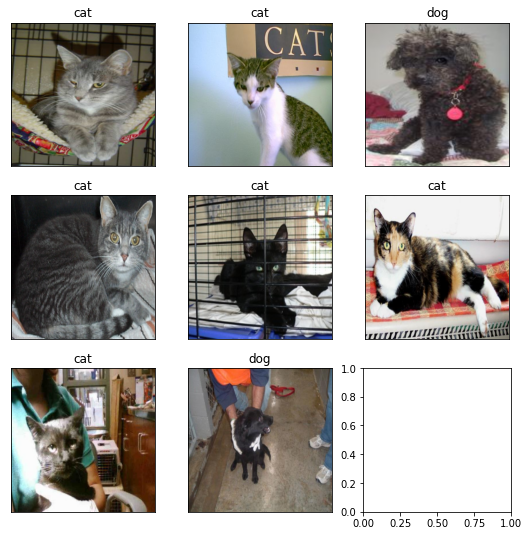

In [28]:
# Show some imags with their labels.
images, labels = batch['image'][1][:9], batch['label'][1][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.


2021-03-03 12:02:23,666 [WARNING] tensorflow: From /usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:201: sample_distorted_bounding_box (from tensorflow.python.ops.image_ops_impl) is deprecated and will be removed in a future version.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.


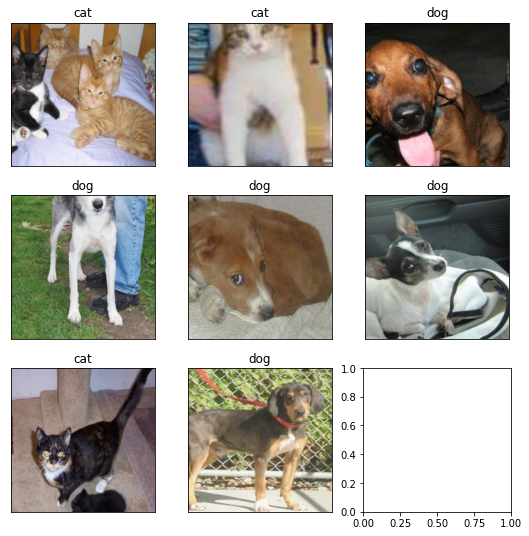

In [29]:
# Same as above, but with train images.
# Do you spot a difference?
# Check out input_pipeline.get_data() in the editor at your right to see how the
# images are preprocessed differently.
batch = next(iter(ds_train.as_numpy_iterator()))
images, labels = batch['image'][1][:9], batch['label'][1][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

In [30]:
[print(i.shape) for i in images]

(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)


[None, None, None, None, None, None, None, None]

### Load pre-trained

In [31]:
# Load model definition & initialize random parameters.
VisionTransformer = models.KNOWN_MODELS[model].partial(num_classes=num_classes)
_, params = VisionTransformer.init_by_shape(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    [(batch['image'].shape[1:], batch['image'].dtype.name)])

In [32]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model}.npz',
    init_params=params,
    model_config=models.CONFIGS[model],
    logger=logger,
)

2021-03-03 12:03:29,002 [WARNING] vit_jax.logging: Inspect recovered empty keys:
{'pre_logits'}
2021-03-03 12:03:29,012 [INFO] vit_jax.logging: Inspect extra keys:
{'pre_logits/kernel', 'pre_logits/bias'}
2021-03-03 12:03:29,018 [INFO] vit_jax.logging: load_pretrained: drop-head variant
2021-03-03 12:03:29,024 [INFO] vit_jax.logging: load_pretrained: resized variant: (1, 197, 768) to (1, 577, 768)
2021-03-03 12:03:29,026 [INFO] vit_jax.logging: load_pretrained: grid-size from 14 to 24


### Evaluate

In [33]:
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['cls']).__name__, params['cls'].shape)
print('params_repl.cls:', type(params_repl['cls']).__name__, params_repl['cls'].shape)

params.cls: ndarray (1, 1, 768)
params_repl.cls: ShardedDeviceArray (8, 1, 1, 768)


In [34]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(VisionTransformer.call)

In [35]:
def get_accuracy(params_repl):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  steps = dgscts_test.num_samples // batch_size
  #steps = input_pipeline.get_dataset_info(dataset, 'test')['num_examples'] // batch_size
  for _, batch in zip(tqdm.notebook.trange(steps), ds_test.as_numpy_iterator()):
    predicted = vit_apply_repl(params_repl, batch['image'])
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total

In [36]:
# Random performance without fine-tuning.
get_accuracy(params_repl)

DeviceArray(0.50020033, dtype=float32)

### Fine-tune

In [37]:
# 100 Steps take approximately 15 minutes in the TPU runtime.
total_steps = 10 ## 100
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 8
base_lr = 0.03

In [38]:
# Check out train.make_update_fn in the editor on the right side for details.
update_fn_repl = train.make_update_fn(VisionTransformer.call, accum_steps)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
opt = momentum_clip.Optimizer(grad_norm_clip=grad_norm_clip).create(params)
opt_repl = flax.jax_utils.replicate(opt)

In [39]:
lr_fn = hyper.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
# Prefetch entire learning rate schedule onto devices. Otherwise we would have
# a slow transfer from host to devices in every step.
lr_iter = hyper.lr_prefetch_iter(lr_fn, 0, total_steps)
# Initialize PRNGs for dropout.
update_rngs = jax.random.split(jax.random.PRNGKey(0), jax.local_device_count())

In [ ]:
# The world's simplest training loop.
# Completes in ~20 min on the TPU runtime.
for step, batch, lr_repl in zip(
    tqdm.notebook.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
    lr_iter
):

  print("loop", step, batch['image'].shape, batch['label'].shape)

  opt_repl, loss_repl, update_rngs = update_fn_repl(
      opt_repl, lr_repl, batch, update_rngs)
  
  print("fini la loop", type(opt_repl), type(loss_repl), type(update_rngs))

loop 1 (8, 8, 384, 384, 3) (8, 8, 2)
print 1
print 2
print 3
print 4
. print 2.1
. print 2.2
. print 1.1
. print 1.2
. print 2.1
. print 2.2
. print 1.1
. print 1.2
print 5
print 6
print 7
<class 'flax.optim.base.Optimizer'> <class 'jax.interpreters.partial_eval.DynamicJaxprTracer'> <class 'jax.interpreters.partial_eval.DynamicJaxprTracer'>


In [ ]:
# Should be ~97.2% for CIFAR10
# Should be ~71.2% for CIFAR100
get_accuracy(opt_repl.target)

2021-01-22 15:02:42,559 [INFO] absl: Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2


DeviceArray(0.96977794, dtype=float32)

### Inference

In [ ]:
# Download model pre-trained on imagenet21k and fine-tuned on imagenet2012.
![ -e "$model"_imagenet2012.npz ] || gsutil cp gs://vit_models/imagenet21k+imagenet2012/"$model".npz "$model"_imagenet2012.npz

Copying gs://vit_models/imagenet21k+imagenet2012/ViT-B_16.npz...
\ [1 files][331.4 MiB/331.4 MiB]                                                
Operation completed over 1 objects/331.4 MiB.                                    


In [ ]:
VisionTransformer = models.KNOWN_MODELS[model].partial(num_classes=1000)
# Load and convert pretrained checkpoint.
params = checkpoint.load(f'{model}_imagenet2012.npz')
params['pre_logits'] = {}  # Need to restore empty leaf for Flax.

In [ ]:
# Get imagenet labels.
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

--2021-01-22 15:07:35--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0.06s   

2021-01-22 15:07:35 (336 KB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



--2021-01-22 15:07:48--  https://picsum.photos/384
Resolving picsum.photos (picsum.photos)... 104.26.4.30, 172.67.74.163, 104.26.5.30, ...
Connecting to picsum.photos (picsum.photos)|104.26.4.30|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://i.picsum.photos/id/611/384/384.jpg?hmac=wN4JxuGz8V51ZYPEEYB_bEnrT5YOV8Z1GZaWznZ_VGM [following]
--2021-01-22 15:07:50--  https://i.picsum.photos/id/611/384/384.jpg?hmac=wN4JxuGz8V51ZYPEEYB_bEnrT5YOV8Z1GZaWznZ_VGM
Resolving i.picsum.photos (i.picsum.photos)... 172.67.74.163, 104.26.5.30, 104.26.4.30, ...
Connecting to i.picsum.photos (i.picsum.photos)|172.67.74.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘picsum.jpg’

picsum.jpg              [ <=>                ]  20.68K  --.-KB/s    in 0.09s   

2021-01-22 15:07:53 (226 KB/s) - ‘picsum.jpg’ saved [21177]



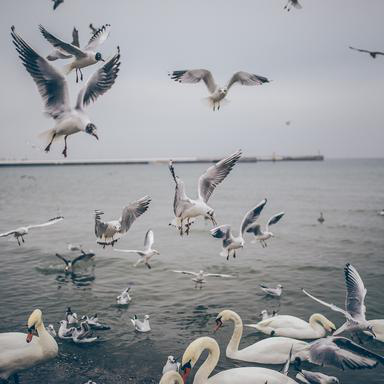

In [ ]:
# Get a random picture with the correct dimensions.
!wget https://picsum.photos/384 -O picsum.jpg
import PIL
img = PIL.Image.open('picsum.jpg')
img

In [ ]:
# Predict on a batch with a single item (note very efficient TPU usage...)
logits, = VisionTransformer.call(params, (np.array(img) / 128 - 1)[None, ...])

In [ ]:
preds = flax.nn.softmax(logits)
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')

0.32265 : lakeside, lakeshore
0.18488 : goose
0.12031 : albatross, mollymawk
0.09743 : pelican
0.04861 : seashore, coast, seacoast, sea-coast
0.01717 : red-breasted_merganser, Mergus_serrator
0.00906 : promontory, headland, head, foreland
0.00862 : black_swan, Cygnus_atratus
0.00720 : American_egret, great_white_heron, Egretta_albus
0.00628 : breakwater, groin, groyne, mole, bulwark, seawall, jetty


## 3) Nos test

### Resize sans garder les proportions

--2021-01-22 15:17:14--  https://lorraine.gatech.edu/sites/default/files/uploads/images/superblock_images/metz-campus.jpeg
Resolving lorraine.gatech.edu (lorraine.gatech.edu)... 130.207.188.153
Connecting to lorraine.gatech.edu (lorraine.gatech.edu)|130.207.188.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 633245 (618K) [image/jpeg]
Saving to: ‘pic_gatech.jpg’

pic_gatech.jpg      100%[===================>] 618.40K  1.93MB/s    in 0.3s    

2021-01-22 15:17:14 (1.93 MB/s) - ‘pic_gatech.jpg’ saved [633245/633245]



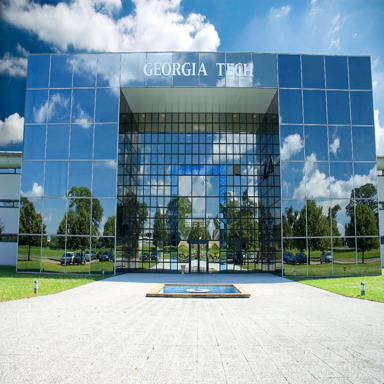

In [ ]:
# Get a random picture with the correct dimensions.
!wget https://lorraine.gatech.edu/sites/default/files/uploads/images/superblock_images/metz-campus.jpeg -O pic_gatech.jpg
import PIL
img = PIL.Image.open('pic_gatech.jpg')
#img
img = img.resize((384,384))
img

In [ ]:
# Predict on a batch with a single item (note very efficient TPU usage...)
logits, = VisionTransformer.call(params, (np.array(img) / 128 - 1)[None, ...])

In [ ]:
preds = flax.nn.softmax(logits)
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')

0.34080 : library
0.11864 : planetarium
0.08288 : brass, memorial_tablet, plaque
0.05962 : triumphal_arch
0.02916 : flagpole, flagstaff
0.02884 : prison, prison_house
0.02557 : fountain
0.01833 : palace
0.01725 : window_screen
0.01429 : doormat, welcome_mat


### Resize en gardant une propostion carré

--2021-01-22 16:16:13--  https://lorraine.gatech.edu/sites/default/files/uploads/images/superblock_images/metz-campus.jpeg
Resolving lorraine.gatech.edu (lorraine.gatech.edu)... 130.207.188.153
Connecting to lorraine.gatech.edu (lorraine.gatech.edu)|130.207.188.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 633245 (618K) [image/jpeg]
Saving to: ‘pic_gatech.jpg’

pic_gatech.jpg      100%[===================>] 618.40K  2.06MB/s    in 0.3s    

2021-01-22 16:16:14 (2.06 MB/s) - ‘pic_gatech.jpg’ saved [633245/633245]



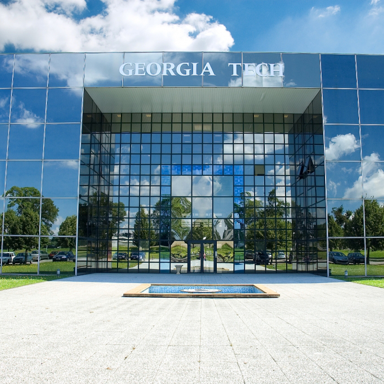

In [ ]:
# Get a random picture with the correct dimensions.
!wget https://lorraine.gatech.edu/sites/default/files/uploads/images/superblock_images/metz-campus.jpeg -O pic_gatech.jpg
import PIL
img = PIL.Image.open('pic_gatech.jpg')

(w, h) = (img.width, img.height)
if w>=h:
  crop_box = ((w/2)-(h/2), 0, (w/2)+(h/2), h)
else:
  crop_box = ((h/2)-(w/2), 0, (h/2)+(w/2), w)

img = img.resize((384,384), box=crop_box)
img

In [ ]:
# Predict on a batch with a single item (note very efficient TPU usage...)
logits, = VisionTransformer.call(params, (np.array(img) / 128 - 1)[None, ...])

In [ ]:
preds = flax.nn.softmax(logits)
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')

0.42597 : library
0.16383 : planetarium
0.04086 : brass, memorial_tablet, plaque
0.02817 : prison, prison_house
0.02799 : palace
0.02688 : fountain
0.02536 : triumphal_arch
0.02456 : flagpole, flagstaff
0.01890 : cinema, movie_theater, movie_theatre, movie_house, picture_palace
0.01539 : window_screen
